In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
mnist = tf.keras.datasets.mnist
tf.disable_control_flow_v2

AttributeError: ignored

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train/255, X_test/255 

In [ ]:
X_train = tf.reshape(X_train,[-1,28*28])
X_test = tf.reshape(X_test,[-1,28*28])
y_train = np.asarray(y_train, dtype = np.int32)
y_test = np.asarray(y_test, dtype = np.int32)

In [ ]:
tf.enable_eager_execution()

In [ ]:
X_train = X_train.numpy()
X_test = X_test.numpy()

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
X_test.shape

(10000, 784)

Text(0.5, 1.0, 'Classe: 0')

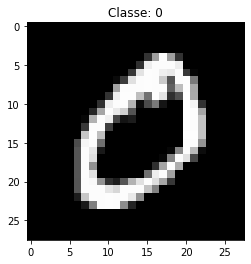

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train[1].reshape((28,28)), cmap = 'gray')
plt.title('Classe: ' + str(y_train[1]))

In [ ]:
def create_network(features, labels, mode):
    #batch_size, Width, Height, Channels
    inputs = tf.reshape(features['X'], [-1, 28, 28, 1])
 
    #Receive [batch_size, 28, 28, 1]
    #Return  [batch_size, 28, 28, 32]
    convolution1 = tf.layers.conv2d(inputs = inputs, filters = 32, kernel_size=[5,5], activation=tf.nn.relu, 
                                padding='same')
 
    #Receive [batch_size, 28, 28, 32]
    #Return  [batch_size, 14, 14, 32]
    pooling1 = tf.layers.max_pooling2d(inputs= convolution1, pool_size=[2,2], strides=2)
 
    #Receive [batch_size, 14, 14, 32]
    #Return  [batch_size, 14, 14, 64]
    convolution2 = tf.layers.conv2d(inputs=pooling1, filters=64, kernel_size=[5,5], activation=tf.nn.relu,
                                padding='same')
    #Receive [batch_size, 14, 14, 64]
    #Return  [batch_size,  7,  7, 64]
    pooling2 = tf.layers.max_pooling2d(inputs=convolution2, pool_size=[2,2], strides=2)
 
    #Receive [batch_size, 7, 7, 64]
    #Return  [batch_size, 3136]
    flattening = tf.reshape(pooling2, [-1, 7*7 * 64])
 
    #inputs_layers = 3136  -> hidden_layers = 1024  -> output_layers = 10 
    #Receive [batch_size, 3136]
    #Return  [batch_size, 1024]
    dense  = tf.layers.dense(inputs=flattening, units=1024, activation=tf.nn.relu)
 
    #Dropout
    dropout = tf.layers.dropout(inputs=dense, rate=0.2, training = mode == tf.estimator.ModeKeys.TRAIN)
 
    #Receive [batch_size, 1024]
    #Return  [batch_size, 10]
    output = tf.layers.dense(inputs= dropout, units=10)
 
    predictions = tf.argmax(output, axis=1)
 
    error = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=output)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)
 
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train = optimizer.minimize(error, global_step = tf.train.get_global_step())
 
        return tf.estimator.EstimatorSpec(mode = mode, loss=error, train_op = train)  
 
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metrics_ops = {'accuracy': tf.metrics.accuracy(labels = labels, predictions = predictions)}
    
        return tf.estimator.EstimatorSpec(mode = mode, loss = error, eval_metric_ops = eval_metrics_ops)

In [ ]:
classifier = tf.estimator.Estimator(model_fn=create_network)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp49_ve4ig', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:

function_train = tf.estimator.inputs.numpy_input_fn(x = {'X': X_train}, y = y_train,
                                                    batch_size = 128, num_epochs=None, shuffle=True)
classifier.train(input_fn=function_train, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp49_ve4ig/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.309487819671631, step = 0
INFO:tensorflow:global_step/sec: 115.758
INFO:tensorflow:loss = 0.09861104935407639, step = 100 (0.866 sec)
INFO:tensorflow:global_step/sec: 124.226
INFO:tensorflow:loss = 0.006578999105840921, step = 200 (0.803 sec)
INFO:tensorflow:global_step/sec: 125.488
INFO:tensorflow:loss = 0.06513562798500061, step = 300 (0.797 sec)
INFO:tensorflow:global_step/sec: 125.843
INFO:tensorflow:loss = 0.04000949114561081, step = 400 (0.797 sec)
INFO:tensorflow:global_step/sec: 125.282
INFO:tensorflo

In [ ]:
function_test = tf.estimator.inputs.numpy_input_fn(x = {'X': X_test}, y = y_test, num_epochs = 1,
                                                      shuffle = False)
results = classifier.evaluate(input_fn=function_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-24T13:59:01Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp49_ve4ig/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.46895s
INFO:tensorflow:Finished evaluation at 2020-06-24-13:59:01
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.99, global_step = 1000, loss = 0.028220244
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp49_ve4ig/model.ckpt-1000


In [ ]:
X_imagem_test = X_test[0]
X_imagem_test.shape

(784,)

In [ ]:
X_imagem_test = X_imagem_test.reshape(1, -1)
X_imagem_test.shape

(1, 784)

In [ ]:
function_prevision = tf.estimator.inputs.numpy_input_fn(x = {'X': X_imagem_test}, shuffle = False)
pred = list(classifier.predict(input_fn = function_prevision))

INFO:tensorflow:Calling model_fn.


ValueError: ignored

In [ ]:
pred[1]

In [ ]:
plt.imshow(X_imagem_test.reshape((28,28)), cmap='gray')